# Logistic Regression - Predicting shipwreck survival

In this week's assignment you will implement a classification algorithm named Logistic Regression. This sounds very counter-intuitive, as regression is something entirely different than classification, but the Logistic Regression model is actually estimating ("regressing") the probability (which is a continuous value) that data can be assigned to a specific class out of a set of classes. We will focus on so-called binary classification problems, wherein there are two possible classes. Some of the examples of binary classification problems that Logistic Regression is able to solve are: 

- Email; spam or not spam 
- Online transactions; fraud or not fraud
- Tumor; malignant or benign 

In this notebook, we will be using the classic *Titanic* dataset. This data consists of demographic and traveling information for 891 of the Titanic's passengers, and the ultimate goal is to predict which of these passengers survived. Here is a summary of the data set's attributes:
- PassengerId: passenger ID assigned in this dataset
- Survived: A Boolean indicating whether the passenger survived or not (0 = No; 1 = Yes); this is our target
- Pclass: Passenger class (1 = 1st; 2 = 2nd; 3 = 3rd)
- Name: field containing the name and title of the passenger
- Sex: male/female
- Age: age of the passenger in years
- SibSp: number of siblings/spouses aboard
- Parch: number of parents/children aboard
- Ticket: ticket number
- Fare: passenger fare in British Pounds
- Cabin: location of the cabin, consisting of a letter indicating the deck, and a cabin number.
- Embarked: port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

As you can probably see, the dataset contains a mix of textual, continuous, categorical, and Boolean variables. Before we can get into implementing and applying Logistic Regression, we will have to clean up the data. We will lead you through this process using the tools a data-scientist might use, providing you with the tools that will help you quickly prepare your own data in the future.

In the code below, we have loaded the data and show its first few rows.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('titanic.csv')

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### A quick view

From the first five rows we have displayed in the table above, you might be able to see that there are multiple types of variables: we have integers, strings, floats, and a few "NaN"s, which are missing values. Lets take a quick look to see what the types of data that we are dealing with actually are. A tool a data-scientist might use here is Panda's [`df.info()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html), which is a method that can be applied to any `DataFrame` that shows information about a DataFrame including the index, datatype for each column, non-null values, and memory usage.

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


As you can see we have 891 entries, numbered 0 to 890, with 12 different variables each. Of these 12 variables "Survived" will be our target variable. Out of 12 columns, 2 are floats, 5 are integers, and 5 are "objects" which in this case means that they are strings. Out of all of the columns, there are 3 that have some missing values. We will have to fix these missing values later.

Let's take a better look at what the columns that have integers and floats in them look like. For this, we will use Panda's [`df.describe`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html?highlight=describe#pandas.DataFrame.describe) which is a method that can be applied to any `DataFrame` that shows descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

In [3]:
display(data.describe())

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We get a table showing a bunch of statistics for each of the columns. The `count` is the number of values that is not NaN in that specific column. We can also see mean, standard deviation, minimum, maximum, and percentiles for each of the columns. These [percentiles](https://en.wikipedia.org/wiki/Percentile) indicate the value below which a given percentage of the data in the column falls. Let's see what we can conclude from this table and the previous one:

- PassengerId is a column that runs from 1 to 891, indicating the index of a passenger in this dataset. This variable has no intrinsic value and might even make our machine learning model find correlations that are no indication of the truth, so we can delete the whole column later.
- The mean of Survived indicates that out of the 891 people in our dataset, only ~38% of people survived. This can be deduced from the mean of the data in that column, as the values are either zero or 1. As an example, when 90% of these values would be 1, we would end up with a mean of 0.9, as the other values are all zeros.
- There are more people in Passenger Class 3 than in class 1 and 2 combined. This can be concluded from the fact that the from the 50th percentile on every passenger is in third class.
- There is at least one baby in our dataset, with an Age of 0.42, or 5 months. The oldest person is 80 years old. We can see this from the min and max values of the Age column.
- There are 277 people of which we do not know the Age. We have 891 data entries, but the "count" for age is 714. $891 - 714 = 277$ 
- The majority of people has no siblings/spouses aboard. This can be concluded from the percentiles.
- The majority of people has no children/parents aboard. This can be concluded from the percentiles.
- There is a big difference in scale in data. Fare can be up to 512 pounds while the number of children/parents on board is only up to 6.  We can also see this in the standard deviations, where the difference is also very large. In his videos, Andrew Ng talks about feature scaling, which is something we must apply here. We will discuss this later.

Often, these tables can tell you a lot about the data you are working with, and might provide you with intuitions on what would work best for this dataset. We will spend some more time on analysing the data at the end of this notebook.

### Cleaning the data

Let's create a copy of the dataset that does not contain data that we do not need for Logistic Regression. In this case, we will delete the rows containing the Passenger ID, Name, Cabin Number, or Ticket number of each passenger. In a more advanced data processing pipeline we might opt to include this data, but that would include data mining techniques that are beyond the scope of this notebook. Keep in mind that the cabin number, for example, may include information on where the passenger was on the ship, which in turn might give information on if a passenger would have been able to reach a lifeboat timely.

Create a new DataFrame called `clean_data` that is a direct copy of our original `data`, but does not include the colums `['PassengerId', 'Cabin','Name','Ticket']`. Take a look at Panda's [`df.drop`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) which can be used to delete columns from a given `DataFrame`, especially the parameter `axis` is important here. The method returns a `Dataframe` without the columns that were deleted.

In [4]:
### YOUR SOLUTION HERE
clean_data = data.drop(['PassengerId', 'Cabin','Name','Ticket'], axis=1)

In our analysis of the data, we concluded that there were 277 people of which we do not know the age. One could say that the absence of information is also information, but in our case there is no way that our model can calculate a prediction when one of the input variables is absent. When you encounter missing values, you have multiple options for dealing with these missing values: you can delete each row that contains a missing values, you can delete the whole column from the DataFrame, or you can replace the missing values. In our case, deleting the rows would not be an option, as we already do not have a lot of data, and we need as much as possible to create an accurate model. Deleting the column would also not be an option, as the age of a person will probably be a good indicator for whether a person survived or not. The third option, replacing the missing values is good, but we have to find a method that will not skew our results. 

There are multiple ways of replacing missing values, but it is important to find a method that does not affect the outcome of our model too much. As replacing the values randomly will probably create a lot of outliers and will probably result in our model not being able to learn what correlations there are within the data, we will use a method that replaces missing values with values that are as generic as possible. An easy way to do this is to replace all missing values with a value that is inferred from the data that is available.

In the cell below, use Panda's [`df.fillna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html?highlight=fillna#pandas.DataFrame.fillna) to replace every missing value in the age column of `clean_data` with the average age of all non-missing values.

*Hint*: `df.fillna` accepts a value that will be used to replace all missing values. It returns a DataFrame or Series depending on what value you put in. Use `mean()` on the age column to get the average age, and then select the column 'Age' and apply fillna with this mean value. Store the result in the age column to overwrite it.

In [5]:
### YOUR SOLUTION HERE
clean_data['Age'] = clean_data['Age'].fillna(clean_data['Age'].mean())

display(clean_data.describe())

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


As you can see, all missing alues in the column "Age" have now been replaced with the average. This means that the average of the column has not changed. However, this solution is still not ideal. We have changed the standard deviation and the percentiles, which indicates that we have changed the entire distribution of the data. Sadly there is no way to recover the real data, and for now, we will have to settle with this solution.

Finally, we have to transform the columns "Sex" and "Embarked" from categorical data into a type of data that the model can handle. The column Sex has two categories, male or female, while the port where passengers Embarked has three categories: C = Cherbourg, Q = Queenstown, or S = Southampton. In the previous notebook, we have introduced you to one-hot encoding, which is exactly what we will use here. Panda's has a method (as is to be expected) named [`get_dummies`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) that transforms data from categorical to a one-hot encoded set of columns.

In [6]:
# We can drop one of the sexes, as being one of the sexes infers that the passenger can no longer be the other
sex = pd.get_dummies(clean_data['Sex'], drop_first=True)

# This is not the case for port of embarkment, as there are three possibilities here
embark = pd.get_dummies(clean_data['Embarked'])

# We no longer need these columns, as we will replace them soon
clean_data = clean_data.drop(['Sex','Embarked'],axis=1)

# Create the new dataframe with the columns we inferred from the categories in Sex and Embarked
clean_data = pd.concat([clean_data, sex, embark],axis=1)

clean_data.info()
clean_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
male        891 non-null uint8
C           891 non-null uint8
Q           891 non-null uint8
S           891 non-null uint8
dtypes: float64(2), int64(4), uint8(4)
memory usage: 45.4 KB


,Survived,Pclass,Age,SibSp,Parch,Fare,male,C,Q,S
0,0,3,22.0,1,0,7.2500,1,0,0,1
1,1,1,38.0,1,0,71.2833,0,1,0,0
2,1,3,26.0,0,0,7.9250,0,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,0,1


### Final preparations

Now that all data is numerical, we can continue to the next step. We have already observed that there is a big difference in scale in data. In his videos, Andrew Ng talks about feature scaling. In feature scaling you make sure that the different features in your dataset take on similar ranges of values. The idea behind this is that after you apply feature scaling, gradient descent will converge more quickly. 

Scipy's `stat` module has some interesting methods to do this, including the `zscore` method which you might recognise from Andrew's video:

$$ Z_j = \frac{x_j - \mu_j}{\sigma_j} $$

The basic principle here is that it transforms every value in the column $j$ to a value that indicates how many standard deviations the value originally was away from the mean of the data *in that column*. For example: a $Z$-score of $-2$ would indicate that the value was 2 standard deviations below the average, while a $Z$-score of $0$ would indicate that the value was

In the code below, we transform each of the non-categorical datacolumns using the `zscore` method, by applying it to each of the elements within. We do not want to apply this function to our categorical one-hot encoded data, as this would re-introduce ordinality; we applied one-hot encoding to ensure that a something either was part of a class, or wasn't. Note that `zscore` makes sure to use a separate $\mu$ and $\sigma$ for every column. 

In [7]:
from scipy.stats import zscore

non_categorical = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
clean_data[non_categorical] = clean_data[non_categorical].apply(zscore)

display(clean_data.describe())

,Survived,Pclass,Age,SibSp,Parch,Fare,male,C,Q,S
count,891.000000,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,891.000000,891.000000,891.000000,891.000000
mean,0.383838,-8.772133e-17,2.232906e-16,4.386066e-17,5.382900e-17,3.987333e-18,0.647587,0.188552,0.086420,0.722783
std,0.486592,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,0.477990,0.391372,0.281141,0.447876
min,0.000000,-1.566107e+00,-2.253155e+00,-4.745452e-01,-4.736736e-01,-6.484217e-01,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-3.693648e-01,-5.924806e-01,-4.745452e-01,-4.736736e-01,-4.891482e-01,0.000000,0.000000,0.000000,0.000000
50%,0.000000,8.273772e-01,0.000000e+00,-4.745452e-01,-4.736736e-01,-3.573909e-01,1.000000,0.000000,0.000000,1.000000
75%,1.000000,8.273772e-01,4.079260e-01,4.327934e-01,-4.736736e-01,-2.424635e-02,1.000000,0.000000,0.000000,1.000000
max,1.000000,8.273772e-01,3.870872e+00,6.784163e+00,6.974147e+00,9.667167e+00,1.000000,1.000000,1.000000,1.000000


The columns that we have adjusted with our `zscore` function now all have a mean that is very close to zero, and a standard deviation that is very close to one. This means that our data is now sufficiently of equal scale and mean-centered.

The final thing that we have to do to prepare the data, is separate the input variables from the target variable, and split the dataset into a training and test set.

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into target "y" and input "X"
y = clean_data['Survived']
X = clean_data.drop('Survived', axis=1)

#Split the data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

### The logistic function

For logistic regression, we require a function that generates probabilities; a function that gives outputs between 0 and 1 for **all** inputs. There are many functions that meet this description, but the one that is used in logistic regression is the logistic function:

$$ g(z) = \frac{1}{1+e^{-z}} $$

Implement the function `logistic_func` that can either take a single value `z`, or an array of values `z`, and compute the *Logistic* function for each.

Then, write some code that can plot the results for the logistic function between $-5$ and $5$. Use Numpy's [`np.linspace`](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html?highlight=linspace#numpy.linspace) to generate a range of $z$ values and use your `logistic_func` to calculate the corresponding $g$ values. Can you see why this function is also sometimes called the *Sigmoid* function? (The term "sigmoid" means S-shaped.)

*Hint:* Numpy built-in functions and basic arithmetic operations work on both Numpy arrays and single values. When the function detects that its input is a Numpy array, the operation it applies will be applied to each element in the array seperately, the result being a Numpy array of the same shape as the input. This is called *element-wise application*. Write your `logistic_func` in such a way that it can compute $g$ values for scalars or for entire vectors.

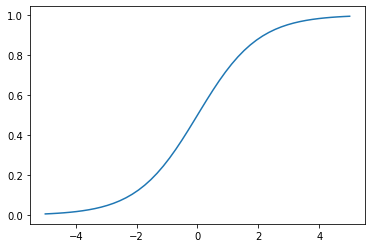

In [9]:
def logistic_func(z):
    ### YOUR SOLUTION HERE
    return 1 / (1 + np.exp(-z))

assert logistic_func(0) == 0.5
assert logistic_func(1) == np.e / (1 + np.e)
assert np.allclose(logistic_func(np.array([0,1])), np.array([0.5, np.e/ (1 + np.e)]))

### YOUR SOLUTION HERE
z = np.linspace(-5, 5)
g = logistic_func(z)

plt.plot(z, g)
plt.show()

### Hypothesis function

We now have a method of transforming our inputs into probabilities, and can now start working on the hypothesis function which will generate an output given a set of inputs $X$ -- in our case the features we created from the Titanic data set -- and a given set of weights $\theta$ -- which we will try to learn from our dataset.

For logistic regression, we can use the logistic function $g$ to transform the hypothesis we used in multivariate linear regression to a hypothesis function that only generates probabilities (results from 0 to 1):

$$ h_\theta(x^1) = g(\theta^Tx^1) = g(z^1) = \frac{1}{1+e^{-z^1}} = \frac{1}{1+e^{-\theta^Tx^1}}$$
$$ h_\theta(x^2) = g(\theta^Tx^2) = g(z^2) = \frac{1}{1+e^{-z^2}} = \frac{1}{1+e^{-\theta^Tx^2}}$$
$$ h_\theta(x^3) = g(\theta^Tx^3) = g(z^3) = \frac{1}{1+e^{-z^3}} = \frac{1}{1+e^{-\theta^Tx^3}}$$
$$\dots$$
$$ h_\theta(x^n) = g(\theta^Tx^n) = g(z^n) = \frac{1}{1+e^{-z^n}} = \frac{1}{1+e^{-\theta^Tx^n}}$$


Herein, $z^i$ is the linear combination of the i-th input vector $x^i$ and the parameter vector $\theta$.

Now, in our text on [the logistic function](#The-logistic-function) just above this text, we discussed how Numpy is able to apply functions element-wise. Using the matrix multiplication we have also used in multivariate linear regression, we can generate a column vector of predictions that have not yet been transformed into probabilities: 

$$ \left[\begin{array}{cccc}
x_0^1 & x_1^1 & x_2^1 & \cdots & x_n^1 \\ 
x_0^2 & x_1^2 & x_2^2 & \cdots & x_n^2 \\ 
x_0^3 & x_1^3 & x_2^3 & \cdots & x_n^3 \\ 
\vdots & \vdots & \vdots & \ddots & \vdots \\
x_0^m & x_1^m & x_2^m & \cdots & x_n^m \\ 
\end{array} \right]
\left[\begin{array}{c} \theta_0 \\ \theta_1 \\
\theta_2 \\ \vdots \\ \theta_n \end{array} \right]
= \left[\begin{array}{cccc}
z^1\\
z^2\\
z^3\\
\dots \\
z^m \\
\end{array} \right]
$$

We can then use our logistic function to apply this function to each of the elements in this column vector of predictions:

$$
\left[\begin{array}{cccc}
g(z^1)\\
g(z^2)\\
g(z^3)\\
\dots \\
g(z^m) \\
\end{array} \right]
=
\left[\begin{array}{c} h_{\theta}(x^1) \\ h_{\theta}(x^2) \\
h_{\theta}(x^3) \\ \vdots \\ h_{\theta}(x^m) \end{array} \right]
$$

Due to Numpy applying the function to each element, instead of the whole vector at once, the only thing that really changes in our programming between the multivariate linear regression model and our new logistic regression model is that we use our logistic function to transform the whole vector of values to be between 0 and 1. To get these prediction values, we can thus just use our old function `linear_model`.

First, copy your implementation of `linear_model`, which you have already implemented in the polynomial regression notebook.

Then, write the function `add_x0`, which takes a matrix of `X` values, and returns that same matrix with a column of ones added to the front. For this function you should use [np.ones](https://numpy.org/doc/stable/reference/generated/numpy.ones.html) to create the column of ones. Then, take a look at [`np.concatenate`](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html?highlight=concat#numpy.concatenate), which enables you to combine the column vector of ones to your matrix `X`.

Then write the function `logistic_model`, which takes a matrix of `X` values, a weight vector `theta`, and calculates $h(X)$ using the functions `add_x0`, `logistic_func`, and `linear_model`. Make sure to first add the bias, or the shapes of the matrix `X` and vector `theta` won't match up!

In [10]:
def linear_model(X, theta):
    ### YOUR (COPIED) SOLUTION HERE
    return X.dot(theta)

def add_x0(X):
    ### YOUR SOLUTION HERE
    return np.concatenate((np.ones((X.shape[0],1)), X), axis=1)

def logistic_model(X, theta):
    ### YOUR SOLUTION HERE
    X = add_x0(X)
    
    return logistic_func(linear_model(X, theta))

### Cost function

Now that we can make predictions using an input matrix $X$, and our parameter weights $\theta$, we can evaluate the cost of our model. To be able to apply gradient descent, we will need a cost function that is convex when we use our logistic model to make predictions. This cost function is explained in great detail by Andrew Ng, so we will not explain it again here. The logistic regression cost function is given as:

$$J(\theta) = - \frac{1}{m} \sum_{i=1}^M y^i log(h_\theta(X^i)) + (1 - y^i) log(1 - h_\theta(X^i))$$

Implement the function `logistic_cost`. Use your `logistic_model` function to calculate the hypothesis vector $h_\theta(X)$. Just as with the cost function for Polynomial Regression, it is actually possible to write this whole function using linear algebra. 

*Hint:* By using `np.log` to apply the logarithm function to every element of a vector, you can calculate the logarithm of every element in the vector $h_\theta(X)$ at once. If you are stuck on how to do this, first try to implement the function by looping over $i$, calculating the cost for each of the separate input and output vectors and summing the results.

In [11]:
def logistic_cost(theta, X, y):
    ### YOUR SOLUTION HERE
    h_X = logistic_model(X, theta)

    return -(y.dot(np.log(h_X)) + (1 - y).dot(np.log(1 - h_X))) / X.shape[0]

## Obtaining the Gradient terms for Logistic Regression

Manually taking the whole partial derivative of this cost function can be a little time consuming, but in order to still practice this skill, we'll just do a part of this derivative instead. For this part of the notebook, you should consult the `logistic_derivative.pdf` supplement, included as a part of the assignment. Read sections 1, 2 and 3 in the supplement, and then complete the steps of the partial derivative below, labeling each of the steps with their respective rules (as with the linear regression assignment).

$$\frac{\partial E_{\mathbf{\theta}}^i}{\partial h_{\mathbf{\theta}}^i} =
\frac{\partial}{\partial h_{\mathbf{\theta}}^i} -y^i log(h_{\mathbf{\theta}}^i) -
(1 - y^i) log(1 - h_{\mathbf{\theta}}^i)$$

**TODO:** *Your steps, each labeled with what rules you've applied, should go here*.

$$\frac{\partial E_{\mathbf{\theta}}^i}{\partial h_{\mathbf{\theta}}^i} =
\frac{-y^i}{h_{\mathbf{\theta}}^i} +
\frac{1 - y^i}{1 - h_{\mathbf{\theta}}^i}$$

Section 4 of the supplement is optional, but definitely read sections 5 and 6 before moving on to the next step. 

### Gradient Vector and Gradient Descent

In the end, the partial derivatives for each of the $\theta$ parameters look the exactly same as for polynomial regression. While the applied hypothesis function $h$ changes, the rest of the derivative does not, even though the cost function is completely different. As a result, the equations for the $n+1$ partial derivatives for each of the $n+1$ parameters, in the notation of the theory videos, then just become:

$$\frac{\partial J}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m (h_{\theta}(x^i) - y^i)x^i_0$$
$$\frac{\partial J}{\partial \theta_1} = \frac{1}{m} \sum_{i=1}^m (h_{\theta}(x^i) - y^i)x^i_1$$
$$\frac{\partial J}{\partial \theta_2} = \frac{1}{m} \sum_{i=1}^m (h_{\theta}(x^i) - y^i)x^i_2$$
$$\dots$$
$$\frac{\partial J}{\partial \theta_n} = \frac{1}{m} \sum_{i=1}^m (h_{\theta}(x^i) - y^i)x^i_n$$

Copy your implementation of `gradient_vector` and `gradient_descent`, which you have already implemented in the polynomial regression notebook. *Change `gradient_vector` to make use of the new hypothesis function `logistic_model`.*

In [12]:
def gradient_vector(theta, X, y):
    ### YOUR (COPIED) SOLUTION HERE
    h_X = logistic_model(X, theta)
    
    X = add_x0(X)
    
    return (h_X - y).dot(X) / X.shape[0]
    
def gradient_descent(X, y, theta, alpha, thres=10**-6):
    ### YOUR (COPIED) SOLUTION HERE
    cost = logistic_cost(theta, X, y)
    cost_hat = cost + 1
    
    while (abs(cost - cost_hat) > thres):
        cost = cost_hat
        theta = theta - alpha * gradient_vector(theta, X, y)

        cost_hat = logistic_cost(theta, X, y)

    print(cost)
    return theta

# Find the theta vector that minimizes the cost function
theta = gradient_descent(X_train, y_train, np.zeros(X_train.shape[1] + 1), 10**-5)

print(theta)

0.6604159914274931
[-3.01634284e-02 -5.03008451e-02 -1.30059812e-02 -2.51839250e-05
  1.45816825e-02  3.74960032e-02 -5.65759930e-02  2.67541741e-03
 -1.90510352e-03 -3.09337423e-02]


### Predictions

We now have a learned vector of weights $\theta$ that we can use to make predictions for our test samples `X_test`. We can re-use our hyptohesis function to calculate the probability that each of the samples in `X_test` is a survivor or not: $p(y=1|X_{test},\theta)$. These estimates of the probability that $y=1$ still need to be transformed into boolean predictions; we predict that either the person has survived $y=1$, or that the person has not survived $y=0$.

Write the function `predict`, that uses a matrix of input values `X` and a vector of weights `theta`, and transforms them into a vector of boolean predictions. Use `logistic_model` to generate predictions, and then use a decision boundary of $h_\theta(x) \leq 0.5$ to determine when $y=1%.

In [13]:
def predict(X, theta):
    ### YOUR SOLUTION HERE
    return logistic_model(X, theta) >= 0.5

predictions = predict(X_test, theta)

### Determining accuracy

Of course we would like to see how *accurate* our model is now that we have trained it and generated predictions! Implement the function `calc_accuracy` that accepts a vector of `predictions` and a vector of truth values `y`. The function should return the factor of correct predictions (predictions where the value in `predictions` is equal to the value in `y`).

In [14]:
def calc_accuracy(predictions, y):
    ### YOUR SOLUTION HERE
    return sum(predictions == y) / len(y)

print(calc_accuracy(predictions, y_test))

0.6865671641791045


### Confusion matrix

The accuracy we have just determined is of course one of the primary goals of building a model; we generally want a Machine Learning model to be as accurate as possible. However, it does not give much insight into in what way our model was accurate. As an example, let's say that we want to diagnose whether a patient has a virus. Of course we want our model to diagnose as accurately as possible, but we would also prefer that a patient that has the virus was not diagnosed as negative (not having the virus), while the opposite is not as important. Falsely diagnosing a patient as negative could become very harmful for the patient and their environment. 

To give better insight into the performance of a classification algorithm, typically, a confusion matrix is made. The confusion matrix is a table layout that allows quick identification of the performance of a classification algorithm. Each *row* in the matrix represents the data that got predicted as a specific class, while each *column* represents the data that is actually in a class:

<table>
    <thead>
        <tr> <th colspan=2></th><th colspan=2 style="border: 1px solid black;"> Actual class </th> </tr>
        <tr>
            <th colspan=2></th>
            <th style="border: 1px solid black;">P</th>
            <th style="border: 1px solid black;">N</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=2 style="border: 1px solid black;"><b> Predicted class </b></td>
            <td style="border: 1px solid black;"><b> P </b></td>
            <td style="border: 1px solid black;"><b> TP </b></td>
            <td style="border: 1px solid black;"> FP </td>
        </tr>
        <tr>
            <td style="border: 1px solid black;"><b> N </b></td>
            <td style="border: 1px solid black;">FN</td>
            <td style="border: 1px solid black;"><b> TN </b></td>
        </tr>
    </tbody>
</table>

Where:
- P = Positive
- N = Negative
- TP = True Positive, denoting every value that was correctly predicted as positive
- FP = False Positive, denoting every value that was predicted as positive but was actually negative
- TN = True Negative, denoting every value that was correctly predicted as negative
- FN = False Negative, denoting every value that was predicted as negative but was actually positive

For example, using the example of diagnosis of patients, let's say that 100 people take a test, and of these people, 80 actually have the virus. We have two different testing kits that are used to diagnose the patients, and these are the resulting confusion matrices:


##### Testing kit 1
<table>
    <thead>
        <tr> <th colspan=2></th><th colspan=2 style="border: 1px solid black;"> Actual class </th> </tr>
        <tr>
            <th colspan=2></th>
            <th style="border: 1px solid black;">P</th>
            <th style="border: 1px solid black;">N</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=2 style="border: 1px solid black;"><b> Predicted class </b></td>
            <td style="border: 1px solid black;"><b> P </b></td>
            <td style="border: 1px solid black;"><b> 56 </b></td>
            <td style="border: 1px solid black;"> 1 </td>
        </tr>
        <tr>
            <td style="border: 1px solid black;"><b> N </b></td>
            <td style="border: 1px solid black;"> 24 </td>
            <td style="border: 1px solid black;"><b> 19 </b></td>
        </tr>
    </tbody>
</table>

##### Testing kit 2
<table>
    <thead>
        <tr> <th colspan=2></th><th colspan=2 style="border: 1px solid black;"> Actual class </th> </tr>
        <tr>
            <th colspan=2></th>
            <th style="border: 1px solid black;">P</th>
            <th style="border: 1px solid black;">N</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=2 style="border: 1px solid black;"><b> Predicted class </b></td>
            <td style="border: 1px solid black;"><b> P </b></td>
            <td style="border: 1px solid black;"><b> 62 </b></td>
            <td style="border: 1px solid black;"> 10 </td>
        </tr>
        <tr>
            <td style="border: 1px solid black;"><b> N </b></td>
            <td style="border: 1px solid black;"> 18 </td>
            <td style="border: 1px solid black;"><b> 10 </b></td>
        </tr>
    </tbody>
</table>

Now, we can learn a lot from these confusion matrices. First, the calculated accuracy of our first virus diagnosis testing kit is 77%, as 56 people are correctly diagnosed as positive, and 19 people are correctly diagnosed as negative.  The calculated accuracy for the second testing kit is 72%. However, using the first testing kit 24 people have been incorrectly diagnosed as negative, while for the second this was 18. Now, arguably, we would want to use testing kit 2, as even though the total accuracy of this testing kit is lower, this kit produces fewer (harmfull) false negatives. 

Implement the function `confusion_matrix` that, given `predictions` and truth values `y`, creates a 2-dimensional Numpy array that contains the number of TP, FP, FN, and TN.

In [15]:
def confusion_matrix(predictions, y):
    ### YOUR SOLUTION HERE
    TP = sum(predictions == y & predictions)
    TN = sum(predictions == y & ~predictions)
    FP = sum(predictions == 1 & ~y)
    FN = sum(predictions == 0 & y)
    
    return np.array([[TP, FP], [FN, TN]])

print(confusion_matrix(predictions, y_test))

[[260  84]
 [233 157]]


### Correlations and understanding weights

To better understand what relations our model has found in the data we will have to take a look at the weights that our model has learned. The relative size of each weight is a direct indication of how important the corresponding feature is in defining the relationship between the input features and the target output. We can even argue why this is the case, as the hypothesis of our model is entirely dependant on the linear combination of the input values and our weights:

$$ h_{\theta}(x^i) = g(x^i_0 \theta_0 + x^i_1 \theta_1 + \dots + x^i_n \theta_n)$$

The logistic function simply "squashes" the combined positive values to a maximum of 1, and the combined negative values to a minimum of 0. I.e. a negative weight means that a large value for this feature will actually decrease the chances of survival for a passenger. 

The input for our function $g$ is composed out of the sums of each input multiplied with its corresponding weight. Since we have made sure that our data all approximately has equal scale by using the `zscore` method, bigger values for a specific weight result in the input corresponding to that weight having more influence on the hypothesis. Similarly, negative values indicate that there is a negative correlation between the input variable and the hypothesis, while positive values indicate a positive correlation.

Below, we have used Seaborn to create a barplot that shows each of the weights and their corresponding data column names.

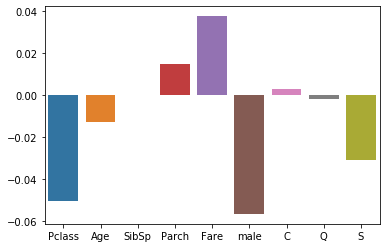

In [16]:
sns.barplot(X_train.columns, theta[1:])
plt.show()

This plot shows that the three most important predictive features seem to be the Passenger Class, the Fare the passenger paid in pounds and whether the passenger was male or female. We cannot directly draw conclusions about the relationship between these features and whether or not a person survived based on this plot, but we *can* use it as a starting point for further analysis.

## Analyzing the data

First, let's take a look at a basic count plot to see how many people have survived overall.

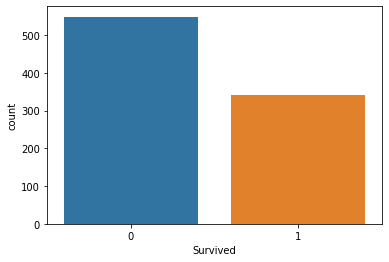

In [17]:
sns.countplot(x='Survived',data=data)
plt.show()

We can see from this plot that approximately 350 people have survived, while approximately 550 people have died overall.

Now, lets take a look at those 3 most predictive features specifically, and see how they affect the distribution.

### 1. Gender of the passenger

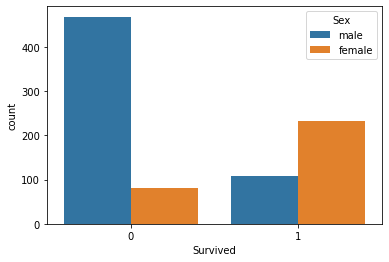

In [18]:
sns.countplot(x='Survived',hue='Sex',data=data)
plt.show()

### 2. Class of the passenger's cabin

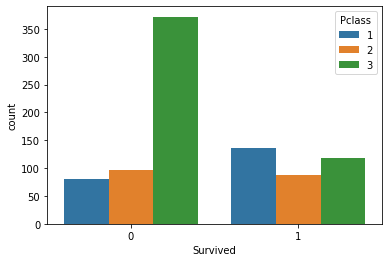

In [19]:
sns.countplot(x='Survived',hue='Pclass',data=data)
plt.show()

### 3. Fare the passenger paid

This is a continous variable, so we can't plot all the the distinct cases. Instead we'll use a barplot with the averages for both classes, and corresponding error bars.

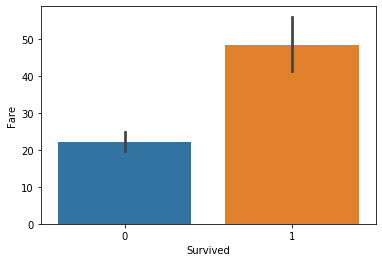

In [24]:

sns.barplot(x='Survived', y='Fare', data=data)
plt.show()

## Creating hypotheses for the data

For each of the 3 features shown above, compare their individual impact on the surival chance of the passenger. For every feature, give your own hypothesis on why this feature is likely to have a positive / negative impact on the survivability of the passenger. Also, add how this then explains the positive or negative weight the feature seems to get in the learned logistic regression model:

#### 1. Gender of the passenger

*Your answer here.*

#### 2. Class of the passenger's cabin

*Your answer here.*

#### 3. Fare the passenger paid

*Your answer here.*
